# # Task 3: Forecast Future Market Trends
#
# Objective:
# Use the best-performing model (LSTM) to forecast Tesla stock prices
# for 6–12 months and analyze trends, uncertainty, opportunities, and risks.

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import load_model
import joblib  # for loading saved scaler

# ==============================
# 1. Load Data
# ==============================

In [14]:
df = pd.read_csv(
    '../data/processed/cleaned_data.csv',
    index_col='Date',
    parse_dates=True
)

tsla = df['TSLA'].dropna()

# ==============================
# 2. Load Model and Scaler
# ==============================

In [15]:
lstm_model = load_model("../models/lstm_tsla_model.keras", compile=False)
scaler = joblib.load("../models/tsla_scaler.save")

# ==============================
# 3. Parameters
# ==============================

In [16]:
WINDOW = 60
FUTURE_DAYS = 252  # ~12 months trading days


# ==============================
# 4. Prepare Last Window and Scale Data
# ==============================

In [17]:
scaled_tsla = scaler.transform(tsla.values.reshape(-1, 1))


last_window = scaled_tsla[-WINDOW:]
current_window = last_window.reshape(1, WINDOW, 1)

future_scaled_predictions = []

# ==============================
# 5. Iterative LSTM Forecast
# ==============================

In [18]:
for _ in range(FUTURE_DAYS):
    next_pred = lstm_model.predict(current_window, verbose=0)[0, 0]
    future_scaled_predictions.append(next_pred)

    # Slide window forward
    current_window = np.append(
        current_window[:, 1:, :],
        [[[next_pred]]],
        axis=1
    )

# ==============================
# 6. Create Future Dates
# ==============================

In [19]:
future_predictions = scaler.inverse_transform(
    np.array(future_scaled_predictions).reshape(-1, 1)
).flatten()


future_dates = pd.bdate_range(
    start=tsla.index[-1],
    periods=FUTURE_DAYS + 1
)[1:]

forecast_df = pd.DataFrame(
    {'Forecast': future_predictions,
     'Upper': future_predictions + 1.96 * residual_std,
     'Lower': future_predictions - 1.96 * residual_std},
    index=future_dates
)
forecast_df.to_csv("../data/processed/tsla_lstm_forecast.csv")


# ==============================
# 7. Estimate Forecast Uncertainty
# ==============================
# Use residuals from last test predictions

In [10]:

historical_window = scaled_tsla[-WINDOW:]
predicted_window = lstm_model.predict(historical_window.reshape(1, WINDOW, 1), verbose=0)
residuals = tsla[-WINDOW:] - scaler.inverse_transform(predicted_window).flatten()
residual_std = residuals.std()

# Apply residual-based confidence intervals
forecast_df['Upper'] = forecast_df['Forecast'] + 1.96 * residual_std
forecast_df['Lower'] = forecast_df['Forecast'] - 1.96 * residual_std


# ==============================
# 8. Visualization
# ==============================

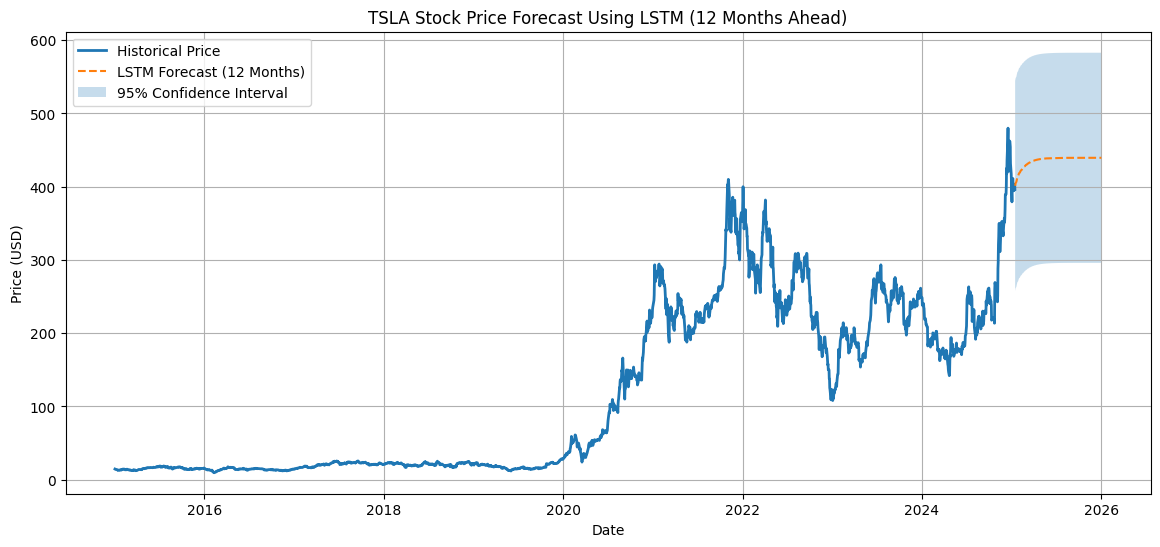

In [11]:
plt.figure(figsize=(14, 6))
plt.plot(tsla.index, tsla, label='Historical Price', linewidth=2)
plt.plot(forecast_df.index, forecast_df['Forecast'],
         label='LSTM Forecast (12 Months)', linestyle='--')
plt.fill_between(
    forecast_df.index,
    forecast_df['Lower'],
    forecast_df['Upper'],
    alpha=0.25,
    label='95% Confidence Interval'
)
plt.title('TSLA Stock Price Forecast Using LSTM (12 Months Ahead)')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.show()